# Executive Summary 
Build a classifier to predict whether or not a passenger survived the Titanic incident based on age, sex, passenger class, where they embarked. 

In [1]:
import os 
import pandas as pd 
import numpy as np 
# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Load Data

In [2]:
TITANIC_PATH = os.path.join("data", "raw")

In [3]:
def load_data(filename, titanic_path=TITANIC_PATH):
    csv_path = os.path.join(titanic_path, filename)
    return pd.read_csv(csv_path)

In [4]:
train_data = load_data("train.csv")
test_data = load_data("test.csv")

In [118]:
train_data.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard,traveling_alone,Name_length
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,None,S,15.0,0,1,3
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S,15.0,0,1,4
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,None,S,NaN,3,0,5
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C,15.0,0,1,4
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,None,Q,30.0,0,1,3


The attributes have the following meaning:
* **Survived**: that's the target, 0 means the passenger did not survive, while 1 means he/she survived.
* **Pclass**: passenger class.
* **Name**, **Sex**, **Age**: self-explanatory
* **SibSp**: how many siblings & spouses of the passenger aboard the Titanic.
* **Parch**: how many children & parents of the passenger aboard the Titanic.
* **Ticket**: ticket id
* **Fare**: price paid (in pounds)
* **Cabin**: passenger's cabin number
* **Embarked**: where the passenger embarked the Titanic

## Examine missing data 


In [6]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.6+ KB


Age and cabin appear to be the categories missing the most values. We can replace the missing values in **Age** with the median values. 

Next we'll examine numerical data: 

In [7]:
train_data.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


- Looking at the Survived column only 38% of people survived. 
- The average age was 29 
- The average fare was 32. 

## Examine categorical values 

In [8]:
train_data["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [9]:
train_data["Pclass"].value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [10]:
train_data["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

The Embarked attribute tells us where the passenger embarked: C=Cherbourg, Q=Queenstown, S=Southampton.

In [11]:
train_data["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

## Transform data

### Build pipeline for numerical data

In [12]:
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
num_attribs = ["Age", "SibSp", "Parch", "Fare"]

num_pipeline = Pipeline([ ("imputer", SimpleImputer(strategy="median")) ])

In [13]:
num_pipeline.fit_transform(train_data[num_attribs])

array([[22.    ,  1.    ,  0.    ,  7.25  ],
       [38.    ,  1.    ,  0.    , 71.2833],
       [26.    ,  0.    ,  0.    ,  7.925 ],
       ...,
       [28.    ,  1.    ,  2.    , 23.45  ],
       [26.    ,  0.    ,  0.    , 30.    ],
       [32.    ,  0.    ,  0.    ,  7.75  ]])

### Build pipeline for categorical data 

In [14]:
from sklearn.base import BaseEstimator, TransformerMixin

# Inspired from stackoverflow.com/questions/25239958
# returns the most frequent item for each selected column 
# fills any nulls with most frequent item 
class MostFrequentImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.most_frequent_ = pd.Series([X[c].value_counts().index[0] for c in X],
                                        index=X.columns)
        return self
    def transform(self, X, y=None):
        return X.fillna(self.most_frequent_)

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
cat_attribs = ["Pclass", "Sex", "Embarked"]
cat_pipeline = Pipeline([
        ("imputer", MostFrequentImputer()),
        ("cat_encoder", OneHotEncoder(sparse=False)),
    ])

In [17]:
cat_pipeline.fit_transform(train_data[cat_attribs])

array([[0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 0., 1.],
       ...,
       [0., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.],
       [0., 0., 1., ..., 0., 1., 0.]])

### Joining numerical to categorical data 

In [18]:
from sklearn.compose import ColumnTransformer

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = full_pipeline.fit_transform(train_data)

In [19]:
# retrieve attribute names 
cat_attribs= list(full_pipeline.transformers_[1][1].named_steps["cat_encoder"].get_feature_names())
cat_attribs

['x0_1', 'x0_2', 'x0_3', 'x1_female', 'x1_male', 'x2_C', 'x2_Q', 'x2_S']

In [20]:
# isolating the training labels
y_train = train_data["Survived"]

# Train models 

## SVC

In [21]:
from sklearn.svm import SVC

svm_clf = SVC(gamma="auto")
svm_clf.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [22]:
X_test = full_pipeline.transform(test_data)
y_pred = svm_clf.predict(X_test)

## Using cross validation we can see how well our model is doing 

In [23]:
from sklearn.model_selection import cross_val_score

svm_scores = cross_val_score(svm_clf, X_train, y_train, cv=10)
svm_scores.mean()

0.7365250822835092

Ok score, but we can probably do better. 

## Random Forest Classifier

In [24]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

## XGBoost Classifier 

In [65]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_clf = GradientBoostingClassifier(random_state=42)
xgb_scores = cross_val_score(xgb_clf, X_train, y_train, cv=10)
xgb_scores.mean()

0.8338905913063217

## Logistic Classifier

In [77]:
from sklearn.linear_model import LogisticRegression

log_clf = LogisticRegression(random_state=42, penalty='l2', solver='liblinear')
log_scores = cross_val_score(log_clf, X_train, y_train, cv=10)
log_scores.mean()

0.8025048235160595

## Visualize models 
Let's plot all 10 scores for each classifier

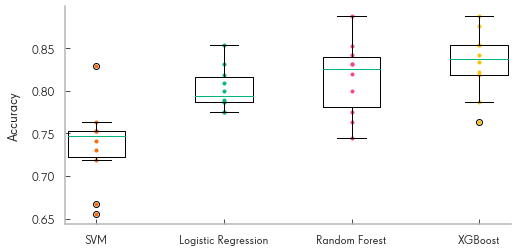

In [84]:
plt.figure(figsize=(8, 4))
plt.plot([1]*10, svm_scores, ".")
plt.plot([2]*10, log_scores, ".")
plt.plot([3]*10, forest_scores, ".")
plt.plot([4]*10, xgb_scores, ".")
plt.boxplot([svm_scores,  log_scores ,forest_scores, xgb_scores], labels=("SVM", 'Logistic Regression',"Random Forest", 'XGBoost'))
plt.ylabel("Accuracy", fontsize=14)
plt.xlim(.75,4.25)
#plt.ylim(.5,1)
plt.show()

# Creating new features 

In [210]:
# try binning Age into AgeBucket 
train_data["AgeBucket"] = train_data["Age"] // 15 * 15
train_data[["AgeBucket", "Survived"]].groupby(['AgeBucket']).mean()

,Survived
AgeBucket,
0.0,0.576923
15.0,0.362745
30.0,0.423256
45.0,0.404494
60.0,0.240000
75.0,1.000000


## add agebucket feature into pipeline 
- adding agebucket as category only produced a score of .812, slightly below the previous result 
- adding AgeBucket as numerical column into pipeline yielded .813 score, again lower than previous 

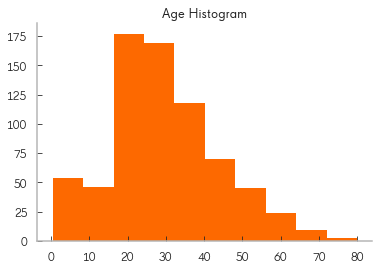

In [27]:
# visualize Age and AgeBucket histograms 
train_data['Age'].hist()
plt.title('Age Histogram');

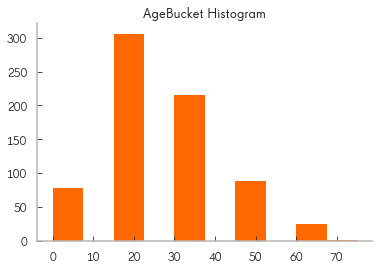

In [28]:
train_data['AgeBucket'].hist()
plt.title('AgeBucket Histogram');

In [29]:
# try lin regression model 
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()
lin_reg = cross_val_score(lin_reg, X_train, y_train, cv=10)
lin_reg.mean()

0.36251023334154475

# Try randomzed grid search 

In [31]:
forest_clf = RandomForestClassifier(n_estimators=100, random_state=42)
forest_scores = cross_val_score(forest_clf, X_train, y_train, cv=10)
forest_scores.mean()

0.8149526160481217

In [32]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint

param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

forest_clf = RandomForestClassifier(random_state=42)
rnd_search = RandomizedSearchCV(forest_clf, param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a183fba90>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a183fbf60>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [33]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.4355163866123252 {'n_estimators': 180, 'max_features': 7}
0.4494665749754947 {'n_estimators': 15, 'max_features': 5}
0.4393649125440716 {'n_estimators': 72, 'max_features': 3}
0.4431800195652587 {'n_estimators': 21, 'max_features': 5}
0.42902546629485455 {'n_estimators': 122, 'max_features': 7}
0.4393649125440716 {'n_estimators': 75, 'max_features': 3}
0.4393649125440716 {'n_estimators': 88, 'max_features': 3}
0.43293169680276444 {'n_estimators': 100, 'max_features': 5}
0.4380858271151806 {'n_estimators': 150, 'max_features': 3}
0.4519567135595372 {'n_estimators': 2, 'max_features': 5}


In [34]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.24599146, 0.04424947, 0.02796221, 0.24324536, 0.02543895,
       0.01417884, 0.06331295, 0.16386151, 0.13577624, 0.01149727,
       0.0073458 , 0.01713992])

In [35]:
trained_columns = num_attribs + cat_attribs
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.24599146108862616, 'Age'),
 (0.2432453642378827, 'Fare'),
 (0.16386151466597493, 'x1_female'),
 (0.1357762444372996, 'x1_male'),
 (0.06331294965164908, 'x0_3'),
 (0.044249473998742885, 'SibSp'),
 (0.027962214203230654, 'Parch'),
 (0.025438946753689153, 'x0_1'),
 (0.017139916449307638, 'x2_S'),
 (0.014178843638266206, 'x0_2'),
 (0.01149727185588034, 'x2_C'),
 (0.007345799019450544, 'x2_Q')]

# Try XGBOOST 

In [177]:
from sklearn.ensemble import GradientBoostingClassifier

xgb_clf = GradientBoostingClassifier(random_state=42)
xgb_scores = cross_val_score(xgb_clf, X_train, y_train, cv=10)
xgb_scores.mean()

0.8294589149926228

In [178]:
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

rnd_search = RandomizedSearchCV(xgb_clf , param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a18e9dfd0>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a18e9e668>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [179]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.20515684, 0.04241942, 0.02678197, 0.11295717, 0.14794885,
       0.30634483, 0.01096909, 0.00866818, 0.01680468, 0.01692768,
       0.00538391, 0.05940301, 0.00886581, 0.01366748, 0.00564703,
       0.0087479 , 0.00330616])

In [180]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

0.41708732973863794 {'n_estimators': 180, 'max_features': 7}
0.4277154618129319 {'n_estimators': 15, 'max_features': 5}
0.42902546629485455 {'n_estimators': 72, 'max_features': 3}
0.4264014327112209 {'n_estimators': 21, 'max_features': 5}
0.41708732973863794 {'n_estimators': 122, 'max_features': 7}
0.4316335478630606 {'n_estimators': 75, 'max_features': 3}
0.4277154618129319 {'n_estimators': 88, 'max_features': 3}
0.4197695910137404 {'n_estimators': 100, 'max_features': 5}
0.4184306096405652 {'n_estimators': 150, 'max_features': 3}
0.6030226891555273 {'n_estimators': 2, 'max_features': 5}


In [181]:
trained_columns = num_attribs + cat_attribs
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.3063448270079564, 'AgeBucket'),
 (0.20515683804334348, 'Fare'),
 (0.14794885428931248, 'traveling_alone'),
 (0.11295716990791965, 'Embarked'),
 (0.0424194166339504, 'Pclass'),
 (0.026781969305853272, 'Sex')]

In [182]:
xgb_scores = cross_val_score(rnd_search.best_estimator_, X_train, y_train, cv=10)
xgb_scores.mean()

0.8328424696402225

# Try combining SibSp and Parch into one column 

In [42]:
train_data["RelativesOnboard"] = train_data["SibSp"] + train_data["Parch"]
train_data[["RelativesOnboard", "Survived"]].groupby(['RelativesOnboard']).mean()

,Survived
RelativesOnboard,
0,0.303538
1,0.552795
2,0.578431
3,0.724138
4,0.200000
5,0.136364
6,0.333333
7,0.000000
10,0.000000


In [43]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0,1
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0,1
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0,1
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0,0


In [44]:
# add traveling alone
train_data['traveling_alone'] = np.where(train_data['RelativesOnboard']==0,1,0)

In [45]:
train_data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,AgeBucket,RelativesOnboard,traveling_alone
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,15.0,1,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,30.0,1,0
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,15.0,0,1
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,30.0,1,0
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,30.0,0,1


# Train with new features 

In [211]:
from sklearn.compose import ColumnTransformer

cat_attribs = ["Pclass", "Sex",'Embarked',  'traveling_alone',  'AgeBucket']
num_attribs = [ "RelativesOnboard", "Fare"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("cat", cat_pipeline, cat_attribs),
    ])

X_train = full_pipeline.fit_transform(train_data)

In [212]:
# train model 
param_distribs = {
        'n_estimators': randint(low=1, high=200),
        'max_features': randint(low=1, high=8),
    }

rnd_search = RandomizedSearchCV(xgb_clf , param_distributions=param_distribs,
                                n_iter=10, cv=5, scoring='neg_mean_squared_error', random_state=42)
rnd_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise-deprecating',
          estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_sampl...      subsample=1.0, tol=0.0001, validation_fraction=0.1,
              verbose=0, warm_start=False),
          fit_params=None, iid='warn', n_iter=10, n_jobs=None,
          param_distributions={'n_estimators': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a18b98780>, 'max_features': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a18b986a0>},
          pre_dispatch='2*n_jobs', random_state=42, refit=True,
          return_train_score='warn', scoring='neg_mean_squared_error',
          verbose=0)

In [213]:
# retrieve attribute names 
cat_attribs_encoded= list(full_pipeline.transformers_[1][1].named_steps["cat_encoder"].get_feature_names())
cat_attribs_encoded

['x0_1',
 'x0_2',
 'x0_3',
 'x1_female',
 'x1_male',
 'x2_C',
 'x2_Q',
 'x2_S',
 'x3_0',
 'x3_1',
 'x4_0.0',
 'x4_15.0',
 'x4_30.0',
 'x4_45.0',
 'x4_60.0',
 'x4_75.0']

In [214]:
feature_importances = rnd_search.best_estimator_.feature_importances_
feature_importances

array([0.08192006, 0.1699774 , 0.04586744, 0.0042519 , 0.09606122,
       0.31327154, 0.16540034, 0.00666192, 0.00525049, 0.01214963,
       0.00382754, 0.00313522, 0.05901834, 0.00736495, 0.01059647,
       0.0042138 , 0.00788706, 0.00314469])

In [215]:
trained_columns = num_attribs + cat_attribs_encoded
sorted(zip(feature_importances,trained_columns), reverse=True)

[(0.3132715440657515, 'x1_female'),
 (0.1699773996860322, 'Fare'),
 (0.16540034362597802, 'x1_male'),
 (0.09606121811357732, 'x0_3'),
 (0.08192005575154601, 'RelativesOnboard'),
 (0.05901833527662207, 'x4_0.0'),
 (0.04586743719495641, 'x0_1'),
 (0.01214963173962052, 'x2_S'),
 (0.010596470322577782, 'x4_30.0'),
 (0.007887059796208675, 'x4_60.0'),
 (0.007364953037001054, 'x4_15.0'),
 (0.006661920717302843, 'x2_C'),
 (0.0052504939470981804, 'x2_Q'),
 (0.00425189721088587, 'x0_2'),
 (0.004213796846597685, 'x4_45.0'),
 (0.0038275368285429177, 'x3_0'),
 (0.0031446857713303294, 'x4_75.0'),
 (0.003135220068370407, 'x3_1')]

In [216]:
xgb_scores = cross_val_score(rnd_search.best_estimator_, X_train, y_train, cv=10)
xgb_scores.mean()

0.8406701849960276

The model performs better without the age feature, but including AgeBucket as a category 

## Title feature 

In [52]:
# split by coma, then by period for not survived 
train_data.loc[(train_data['Survived']==0)]['Name'].apply(lambda x: x.split(',')[1].split('.')[0]).apply(pd.Series).stack().value_counts()

 Mr          436
 Miss         55
 Mrs          26
 Master       17
 Rev           6
 Dr            4
 Don           1
 Col           1
 Major         1
 Capt          1
 Jonkheer      1
dtype: int64

In [53]:
set(train_data.loc[(train_data['Survived']==0)]['Name'].apply(lambda x: x.split(',')[1].split('.')[0]).apply(pd.Series).stack().value_counts().index)

{' Capt',
 ' Col',
 ' Don',
 ' Dr',
 ' Jonkheer',
 ' Major',
 ' Master',
 ' Miss',
 ' Mr',
 ' Mrs',
 ' Rev'}

In [54]:
# survived 
train_data.loc[(train_data['Survived']==1)]['Name'].apply(lambda x: x.split(',')[1].split('.')[0]).apply(pd.Series).stack().value_counts()

 Miss            127
 Mrs              99
 Mr               81
 Master           23
 Dr                3
 Mlle              2
 Col               1
 Ms                1
 Lady              1
 Major             1
 Sir               1
 Mme               1
 the Countess      1
dtype: int64

In [147]:
def set_title(name):
    """Returns the Title in the name string."""
    titles = {
        "Capt.": "Officer",
        "Col.": "Officer",
        "Major.": "Officer",
        "Jonkheer.": "Royalty",
        "Don.": "Royalty",
        "Dona.": "Royalty",
        'Countess.':'Royalty',
        "Sir.": "Royalty",
        "Dr.": "Officer",
        "Rev.": "Officer",
        "the. Countess": "Royalty",
        "Mme.": "Mrs",
        "Mlle.": "Miss",
        "Ms.": "Mrs",
        "Mrs.": "Mrs.",
        "Mr.": "Mr",
        "Miss.": "Miss",
        "Master.": "Master",
        "Lady.": "Royalty"
    }
    
    for key in titles:
        if key in name.split():
            return titles[key]
        
set_title('Braund, Mr. Owen Harris')

'Mr'

In [148]:
# set titles 
train_data['Title'] = train_data['Name'].apply(set_title)

Again the model performs worse with Titles attribute 

# Name Length

In [88]:
train_data['Name_length']=train_data['Name'].apply(lambda x: len(x.split()))

In [89]:
# test name length, find mean for different survival outcomes
train_data.loc[train_data['Survived']==1][['Name_length']].mean()

Name_length    4.476608
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a18e74080>]],
      dtype=object)

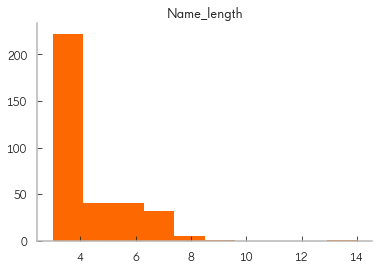

In [90]:
# visualize data 
train_data.loc[train_data['Survived']==1][['Name_length']].hist()

In [91]:
train_data.loc[train_data['Survived']==0][['Name_length']].mean()

Name_length    3.812386
dtype: float64

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1a188069b0>]],
      dtype=object)

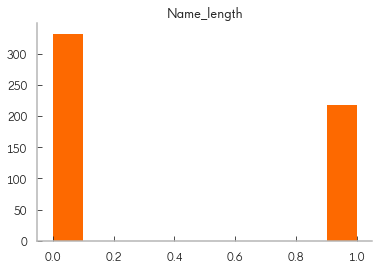

In [87]:
train_data.loc[train_data['Survived']==0][['Name_length']].hist()

In [60]:
train_data['Name_length'] = train_data['Name'].apply(lambda x: 1 if len(x)>25 else 0)

In [85]:
train_data[['Survived', 'Name_length']].head()

,Survived,Name_length
0,0,0
1,1,1
2,1,0
3,1,1
4,0,0


The Name_length feature did not improve the model's score, so we'll leave it out. 

# Add cabin feature 

In [62]:
# replaces nan with None
train_data['Cabin'] = np.where( pd.notnull(train_data['Cabin']), train_data['Cabin'],None)

In [63]:
train_data['Cabin'].describe()

count             204
unique            147
top       C23 C25 C27
freq                4
Name: Cabin, dtype: object

Too much data is missing to do anything meaningful with cabin feature.